In [1]:
import os
import json
import glob
import cv2
import shutil

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from huggingface_hub import snapshot_download
ROOT_DIR = "/home/data/pace"

In [ ]:
## Download PACE Dataset folders

# repo_id = "qq456cvb/PACE"  # Replace with the actual dataset ID
# local_dir = "."  # The local path where you want to save the folder
# allow_patterns = ["model_splits/*"] # To download a specific folder within the dataset
# snapshot_download(repo_id=repo_id, local_dir=local_dir, allow_patterns=allow_patterns, repo_type="dataset")

# len(glob.glob(f'{ROOT_DIR}/test/*')), len(glob.glob(f'{ROOT_DIR}/val_inst/*')) ###, len(glob.glob(f'{ROOT_DIR}/val_pbr_cat/*'))

In [2]:
# Create list of all object classes
all_categories = ['_'.join(x.split('/')[-1].split('_')[:-1]) for x in glob.glob(f'{ROOT_DIR}/model_splits/category/*_train.txt')]
all_categories.sort()
print(f"Total number of unique categories: {len(all_categories)}")

# Compile the data dictionary: data[video_id][frame_id] = set of all instance IDs in that frame of that video
data = dict()

for video_path in glob.glob(f'{ROOT_DIR}/test/*')+glob.glob(f'{ROOT_DIR}/val_inst/*'):
	video_id = int(video_path.split('/')[-1])
	frame_ids = [int(f.split('/')[-1].split('.')[0]) for f in glob.glob(f'{video_path}/rgb/*')]
	data[video_id] = {frame_id: set() for frame_id in frame_ids}
	
	with open(f'{video_path}/scene_gt_coco_det_modal_inst.json', 'r') as f:
		video_json = json.load(f)

	for anno in video_json['annotations']:
		object_instance_id = anno['category_id']
		frame_id = anno['image_id']
		data[video_id][frame_id].add(object_instance_id)

# Create dictionary to fetch all instance IDs for a given category
instances_of_category = dict()
category_of_instance = dict()
for category in all_categories:
	test_instance_ids = [int(x.split('_')[-1]) for x in open(f'{ROOT_DIR}/model_splits/category/{category}_test.txt', 'r').read().splitlines()]
	val_instance_ids = [int(x.split('_')[-1]) for x in open(f'{ROOT_DIR}/model_splits/category/{category}_val.txt', 'r').read().splitlines()]
	instances_of_category[category] = set(test_instance_ids + val_instance_ids)
	
	for instance in instances_of_category[category]:
		category_of_instance[instance] = category

	print(f'Category {category}, has {len(instances_of_category[category])} instances: {instances_of_category[category]}')


# Create set of all instance IDs
all_instances = set()
for cat in instances_of_category:
	all_instances.update(instances_of_category[cat])
print(f'Total number of unique instances: {len(all_instances)}')

Total number of unique categories: 47
Category bottle, has 16 instances: {705, 2, 3, 4, 5, 6, 11, 14, 15, 16, 18, 20, 21, 694, 24, 700}
Category bowl, has 12 instances: {739, 36, 38, 40, 42, 43, 720, 722, 30, 728, 734, 735}
Category box-base_link, has 10 instances: {608, 579, 548, 554, 558, 591, 593, 595, 603, 572}
Category box-link1, has 10 instances: {578, 547, 553, 557, 590, 592, 594, 602, 571, 607}
Category brush, has 7 instances: {48, 49, 50, 51, 53, 55, 56}
Category can, has 17 instances: {66, 70, 71, 72, 73, 74, 778, 766, 761, 758, 57, 58, 59, 764, 61, 62, 63}
Category chip_can, has 8 instances: {75, 76, 77, 78, 79, 81, 82, 789}
Category clip-link1, has 4 instances: {632, 610, 628, 618}
Category clip-link2, has 4 instances: {609, 627, 617, 631}
Category clock, has 9 instances: {808, 792, 93, 85, 87, 88, 89, 90, 797}
Category container, has 7 instances: {96, 97, 815, 823, 825, 829, 95}
Category cutter-base_link, has 5 instances: {642, 646, 650, 636, 638}
Category cutter-link1, ha

# Instance & video train-val-test split

In [23]:
output_dir = f'{ROOT_DIR}/pace_v3'
target_categories = ['toy_car', 'can', 'snack_box', 'ramen_box']
os.makedirs(output_dir, exist_ok=True)

In [24]:
def isInstanceInVideo(instance_id, video_id):
	"""Check if a given instance ID is present in any frame of the specified video."""
	return any(instance_id in frame_instances for frame_instances in data[video_id].values())

def set_union(sets):
    return set().union(*sets)

def sets_are_disjoint(sets):
	"""Check if all sets in the list are disjoint."""
	combined = set()
	for s in sets:
		if not combined.isdisjoint(s):
			return False
		combined.update(s)
	return True

def existInSameVideo(instance1, instance2):
    for video_id in data:
        if isInstanceInVideo(instance1, video_id) and isInstanceInVideo(instance2, video_id):
            return True
    return False

In [25]:
import networkx as nx
from itertools import combinations

/tmp/ipykernel_1004006/250402190.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


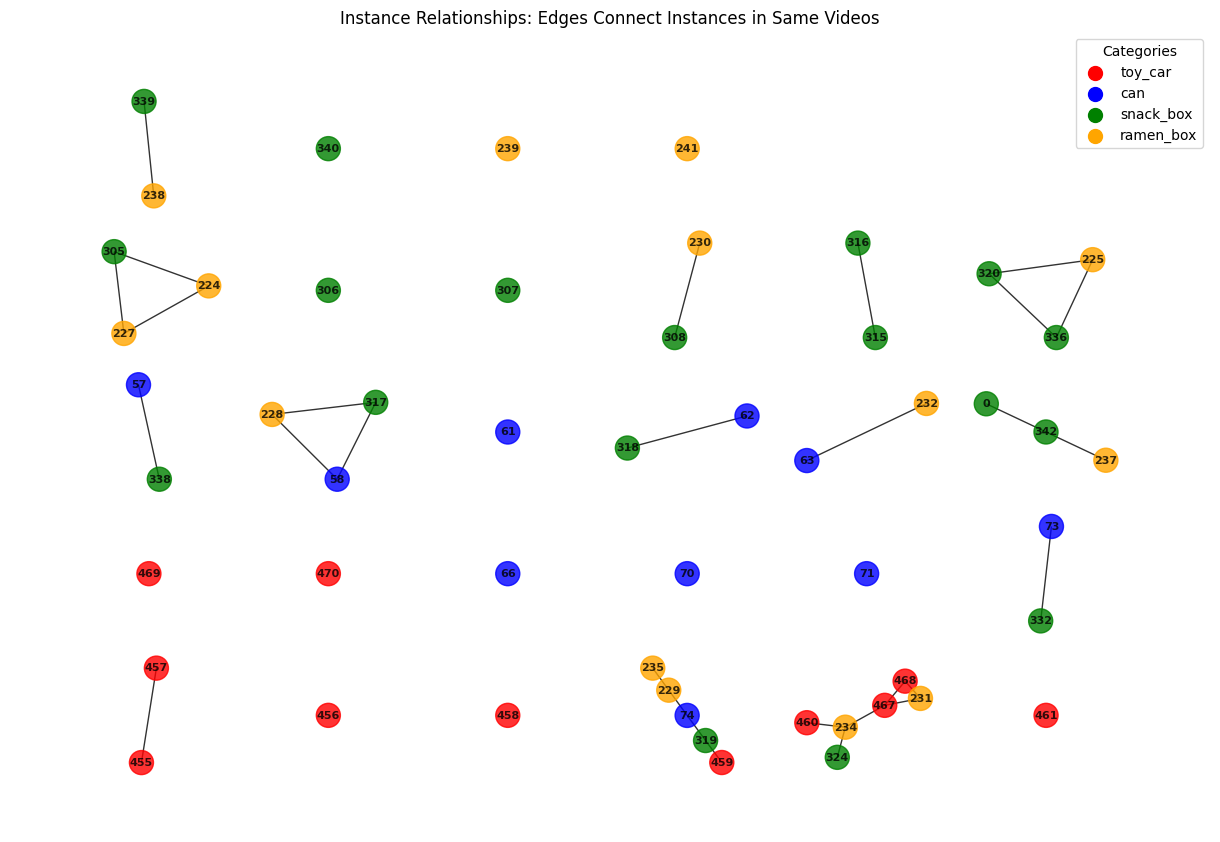

Graph has 53 nodes and 29 edges
Connected components: 28
Component 1: 2 instances - [455, 457]
Component 2: 1 instances - [456]
Component 3: 1 instances - [458]
Component 4: 5 instances - [74, 229, 235, 319, 459]
Component 5: 6 instances - [231, 234, 324, 460, 467, 468]
Component 6: 1 instances - [461]
Component 7: 1 instances - [469]
Component 8: 1 instances - [470]
Component 9: 1 instances - [66]
Component 10: 1 instances - [70]
Component 11: 1 instances - [71]
Component 12: 2 instances - [73, 332]
Component 13: 2 instances - [57, 338]
Component 14: 3 instances - [58, 228, 317]
Component 15: 1 instances - [61]
Component 16: 2 instances - [62, 318]
Component 17: 2 instances - [63, 232]
Component 18: 3 instances - [0, 237, 342]
Component 19: 3 instances - [224, 227, 305]
Component 20: 1 instances - [306]
Component 21: 1 instances - [307]
Component 22: 2 instances - [230, 308]
Component 23: 2 instances - [315, 316]
Component 24: 3 instances - [225, 320, 336]
Component 25: 2 instances - 

In [26]:
# Create a graph to visualize instance relationships
G = nx.Graph()

# Add all target category instances as nodes
target_instances = set()
for category in target_categories:
	for instance in instances_of_category[category]:
		if any(isInstanceInVideo(instance, videoID) for videoID in data.keys()):
			target_instances.add(instance)
			G.add_node(instance, category=category)

# Add edges between instances that appear in the same video
for instance1, instance2 in combinations(target_instances, 2):
	if existInSameVideo(instance1, instance2):
		G.add_edge(instance1, instance2)

# Create visualization
plt.figure(figsize=(12, 8))

# Create color map for different categories
category_colors = {
	'toy_car': 'red',
	'can': 'blue', 
	'snack_box': 'green',
	'ramen_box': 'orange'
}

# Get node colors based on category
node_colors = [category_colors[G.nodes[node]['category']] for node in G.nodes()]

# Calculate positions for each connected component separately
pos = {}
components = list(nx.connected_components(G))
n_components = len(components)

# Arrange components in a grid-like pattern
import math
grid_size = math.ceil(math.sqrt(n_components))

for i, component in enumerate(components):
	# Create subgraph for this component
	subgraph = G.subgraph(component)
	
	# Calculate grid position for this component
	row = i // grid_size
	col = i % grid_size
	
	# Get layout for this component
	if len(component) > 1:
		# Use spring layout for connected components
		sub_pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
	else:
		# Single node component
		sub_pos = {list(component)[0]: (0, 0)}
	
	# Offset positions to separate components
	offset_x = col * 3.0  # Horizontal separation
	offset_y = row * 3.0  # Vertical separation
	
	for node, (x, y) in sub_pos.items():
		pos[node] = (x + offset_x, y + offset_y)

# Draw the graph
nx.draw(G, pos, 
		node_color=node_colors,
		node_size=300,
		with_labels=True,
		font_size=8,
		font_weight='bold',
		alpha=0.8)

# Create legend
legend_elements = [plt.scatter([], [], c=color, s=100, label=category) 
				  for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title='Categories')

plt.title('Instance Relationships: Edges Connect Instances in Same Videos')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print graph statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Connected components: {nx.number_connected_components(G)}")

# Print component information
for i, component in enumerate(nx.connected_components(G)):
	print(f"Component {i+1}: {len(component)} instances - {sorted(list(component))}")

In [27]:
# Find optimal split of components into train/val/test to balance instances per category
def get_component_instance_counts(components, target_categories):
    """Calculate instance counts by category for each component"""
    component_instance_counts = []
    for component in components:
        category_counts = {category: 0 for category in target_categories}
        for instance in component:
            if instance in category_of_instance:
                category = category_of_instance[instance]
                if category in target_categories:
                    category_counts[category] += 1
        component_instance_counts.append(category_counts)
    return component_instance_counts

def balance_split_components_by_instances(components, instance_counts, target_categories, target_ratio=(0.4, 0.2, 0.4)):
    """Split components into train/val/test to balance instances per category"""
    
    # Calculate total instances per category
    total_instances_per_category = {category: 0 for category in target_categories}
    for counts in instance_counts:
        for category in target_categories:
            total_instances_per_category[category] += counts[category]
    
    # Calculate target instances per split per category
    target_counts = {}
    for split_name, ratio in zip(['train', 'val', 'test'], target_ratio):
        target_counts[split_name] = {}
        for category in target_categories:
            target_counts[split_name][category] = total_instances_per_category[category] * ratio
    
    print("Target instance distribution:")
    for split_name in ['train', 'val', 'test']:
        print(f"{split_name}: {target_counts[split_name]}")
    
    # Sort components by total instances (largest first for greedy assignment)
    component_totals = [sum(counts.values()) for counts in instance_counts]
    sorted_indices = sorted(range(len(components)), key=lambda i: component_totals[i], reverse=True)
    
    splits = {'train': [], 'val': [], 'test': []}
    split_counts = {
        'train': {category: 0 for category in target_categories},
        'val': {category: 0 for category in target_categories}, 
        'test': {category: 0 for category in target_categories}
    }
    
    # Greedy assignment: assign each component to the split that needs it most
    for idx in sorted_indices:
        component = components[idx]
        counts = instance_counts[idx]
        
        # Calculate deficit for each split (how far from target)
        split_scores = {}
        for split_name in ['train', 'val', 'test']:
            score = 0
            for category in target_categories:
                if counts[category] > 0:  # Only consider categories present in this component
                    deficit = target_counts[split_name][category] - split_counts[split_name][category]
                    score += deficit * counts[category]  # Weight by how many instances we'd add
            split_scores[split_name] = score
        
        # Assign to the split with the highest score (most needed)
        best_split = max(split_scores.keys(), key=lambda x: split_scores[x])
        splits[best_split].append(component)
        
        # Update counts
        for category in target_categories:
            split_counts[best_split][category] += counts[category]
    
    return splits, split_counts

# Get components and their instance counts by category
components = list(nx.connected_components(G))
component_instance_counts = get_component_instance_counts(components, target_categories)

# Balance the split by instances per category
component_splits, split_instance_counts = balance_split_components_by_instances(
    components, component_instance_counts, target_categories, target_ratio=(0.4, 0.2, 0.4)
)

target_instances_per_split = {'train': set(), 'val': set(), 'test': set()}
for split_name in ['train', 'val', 'test']:
    for component in component_splits[split_name]:
        target_instances_per_split[split_name].update(component)

# Print results
print(f"\nBalanced component splits by instance counts:")
for split_name in ['train', 'val', 'test']:
    num_components = len(component_splits[split_name])
    print(f"\n{split_name:>5}: {num_components:2d} components")
    print(f"       Instance counts by category: {split_instance_counts[split_name]}")
    print(f"       Total instances: {len(target_instances_per_split[split_name])}")
    print(f"       Instance IDs: {sorted(list(target_instances_per_split[split_name]))}")

# Print category distribution summary
print(f"\nCategory distribution across splits:")
for category in target_categories:
    train_count = split_instance_counts['train'][category]
    val_count = split_instance_counts['val'][category] 
    test_count = split_instance_counts['test'][category]
    total_count = train_count + val_count + test_count
    
    print(f"{category:>12}: Train={train_count:2d} ({train_count/total_count*100:4.1f}%), "
          f"Val={val_count:2d} ({val_count/total_count*100:4.1f}%), "
          f"Test={test_count:2d} ({test_count/total_count*100:4.1f}%)")

Target instance distribution:
train: {'toy_car': 4.4, 'can': 4.0, 'snack_box': 7.2, 'ramen_box': 5.6000000000000005}
val: {'toy_car': 2.2, 'can': 2.0, 'snack_box': 3.6, 'ramen_box': 2.8000000000000003}
test: {'toy_car': 4.4, 'can': 4.0, 'snack_box': 7.2, 'ramen_box': 5.6000000000000005}

Balanced component splits by instance counts:

train: 10 components
       Instance counts by category: {'toy_car': 5, 'can': 4, 'snack_box': 7, 'ramen_box': 6}
       Total instances: 22
       Instance IDs: [58, 62, 70, 73, 224, 227, 228, 231, 234, 241, 305, 315, 316, 317, 318, 324, 332, 458, 460, 467, 468, 470]

  val:  8 components
       Instance counts by category: {'toy_car': 2, 'can': 2, 'snack_box': 4, 'ramen_box': 3}
       Total instances: 11
       Instance IDs: [57, 71, 230, 238, 239, 308, 338, 339, 340, 456, 469]

 test: 10 components
       Instance counts by category: {'toy_car': 4, 'can': 4, 'snack_box': 7, 'ramen_box': 5}
       Total instances: 20
       Instance IDs: [0, 61, 63, 66,

In [28]:
instance_splits = {'train': defaultdict(set), 'val': defaultdict(set), 'test': defaultdict(set)}

## FOR EACH OF THE CHOSEN VIDEOS
# for category in target_categories:
# 	instance_splits[category]

for split_name in ['train', 'val', 'test']:
	# Show which instances are in each split
	for instance in target_instances_per_split[split_name]:
		class_name = category_of_instance[instance]
		instance_splits[split_name][class_name].add(instance)

In [29]:
instance_splits

{'train': defaultdict(set,
             {'snack_box': {305, 315, 316, 317, 318, 324, 332},
              'can': {58, 62, 70, 73},
              'toy_car': {458, 460, 467, 468, 470},
              'ramen_box': {224, 227, 228, 231, 234, 241}}),
 'val': defaultdict(set,
             {'ramen_box': {230, 238, 239},
              'can': {57, 71},
              'toy_car': {456, 469},
              'snack_box': {308, 338, 339, 340}}),
 'test': defaultdict(set,
             {'snack_box': {0, 306, 307, 319, 320, 336, 342},
              'can': {61, 63, 66, 74},
              'toy_car': {455, 457, 459, 461},
              'ramen_box': {225, 229, 232, 235, 237}})}

In [ ]:
# video_splits = {'train': dict(), 'val': dict(), 'test': dict()}
# instance_splits = {'train': dict(), 'val': dict(), 'test': dict()}
# distractor_splits = {'train': dict(), 'val': dict(), 'test': dict()}

# instance_splits['train']['toy_car'] = {456, 458, 461, 470}
# instance_splits['val']['toy_car'] = {459, 460, 467, 468}
# instance_splits['test']['toy_car'] = {455, 457, 469}

# instance_splits['train']['can'] = {74, 57, 58}
# instance_splits['val']['can'] = {66, 70, 71, 73}
# instance_splits['test']['can'] = {61, 62, 63}

# instance_splits['train']['distractor'] = {320, 324, 336, 340,    2, 16,    437, 448}
# instance_splits['val']['distractor'] = {315, 316, 317, 318,    5, 6,    434, 435}
# instance_splits['test']['distractor'] = {305, 306, 307, 308,    21, 24,   451, 436}

In [33]:
video_splits = {'train': defaultdict(set), 'val': defaultdict(set), 'test': defaultdict(set)}

# Given the instance splits, construct video splits (all videos containing train instances become train videos, etc.)
IGNORE_VIDEOS = {156, 157, 158} ## MANUALLY ignored videos which contain a toy car instance but were seemingly mislabelled by PACE
# already_assigned_videos = set()
for split in instance_splits:
	for video_id, frames in data.items():
		if video_id in IGNORE_VIDEOS:
			continue
		for instance in target_instances_per_split[split]:
			if isInstanceInVideo(instance, video_id):
				category = category_of_instance[instance]
				video_splits[split][category].add(video_id)

In [34]:
# video_splits = {'train': dict(), 'val': dict(), 'test': dict()}

# # Given the instance splits, construct video splits (all videos containing train instances become train videos, etc.)
# already_assigned_videos = set()
# for split in instance_splits:
# 	for category in instance_splits[split]:
# 		video_splits[split][category] = set()
# 		for instance in instance_splits[split][category]:
# 			# add each video that contains this instance to the split
# 			for video_id, frames in data.items():
# 				if isInstanceInVideo(instance, video_id):
# 					# if the video is already assigned to another category, this may create a conflict
# 					if (video_id in already_assigned_videos) and (video_id not in video_splits[split][category]):
# 						if category == 'distractor':
# 							continue  # Just don't add the distractor videos that would create conflict
# 						raise ValueError(f"Splits are not disjoint! {video_id} is in both {video_splits[split][category]}")

# 					video_splits[split][category].add(video_id)
# 					already_assigned_videos.add(video_id)

for split in video_splits:
	for category in video_splits[split]:
		print(f'{split:>5} | {category:>7} | Videos:    {sorted(list(video_splits[split][category]))}')
		if len(video_splits[split][category]) == 0:
			print(f'Warning: No videos found for split {split} and category {category}.')

for split in video_splits:
	for category in video_splits[split]:
		print(f'{split:>5} | {category:>7} | Instances: {sorted(list(instance_splits[split][category]))}')
		if len(instance_splits[split][category]) == 0:
			print(f'Warning: No instances found for split {split} and category {category}.')

videos_in_data_split = {'train': set(), 'val': set(), 'test': set()} # set of video IDs for each data split
instances_in_data_split = {'train': set(), 'val': set(), 'test': set()} # set of TARGET instance IDs for each data split
for split in video_splits:
	videos_in_data_split[split] = set_union(video_splits[split][category] for category in video_splits[split])
	instances_in_data_split[split] = set_union(instance_splits[split][category] for category in instance_splits[split] if category!='distractor')

## print the number of total frames per data split
for split in videos_in_data_split:
	total_frames = sum(len(data[video_id]) for video_id in videos_in_data_split[split])
	print(f'Total frames in {split} split: {total_frames}')
	
videos_in_category = {category:set() for category in video_splits['train']} # set of video IDs for each category
instances_in_category = {category:set() for category in instance_splits['train']} # set of instance IDs for each category
for category in video_splits[split]:
	videos_in_category[category] = videos_in_category[category].union(video_splits[split][category])
	instances_in_category[category] = instances_in_category[category].union(instance_splits[split][category])

assert sets_are_disjoint([videos_in_data_split['train'], videos_in_data_split['test'], videos_in_data_split['val']])
assert sets_are_disjoint([instances_in_data_split['train'], instances_in_data_split['val'], instances_in_data_split['test']])

print(f'Train videos: {len(videos_in_data_split["train"])}, Train instances: {len(instances_in_data_split["train"])}')
print(f'Val videos: {len(videos_in_data_split["val"])}, Val instances: {len(instances_in_data_split["val"])}')
print(f'Test videos: {len(videos_in_data_split["test"])}, Test instances: {len(instances_in_data_split["test"])}')

train | toy_car | Videos:    [144, 145, 146, 159, 160, 161, 180, 181, 182, 186, 187, 188, 213, 214, 215, 216, 217, 218, 249, 250, 251, 279, 280, 281, 282, 283, 284]
train | ramen_box | Videos:    [6, 7, 8, 15, 16, 17, 24, 25, 26, 123, 124, 125, 138, 139, 140, 159, 160, 161, 174, 175, 176, 246, 247, 248, 249, 250, 251, 270, 271, 272, 279, 280, 281]
train |     can | Videos:    [24, 25, 26, 30, 31, 32, 48, 49, 50, 66, 67, 68, 96, 97, 98]
train | snack_box | Videos:    [15, 16, 17, 18, 19, 20, 24, 25, 26, 30, 31, 32, 57, 58, 59, 78, 79, 80, 96, 97, 98, 138, 139, 140, 153, 154, 155]
  val | toy_car | Videos:    [183, 184, 185, 204, 205, 206, 222, 223, 224, 225, 226, 227]
  val |     can | Videos:    [0, 1, 2, 51, 52, 53]
  val | ramen_box | Videos:    [12, 13, 14, 27, 28, 29, 192, 193, 194, 219, 220, 221]
  val | snack_box | Videos:    [0, 1, 2, 12, 13, 14, 27, 28, 29, 33, 34, 35]
 test | toy_car | Videos:    [120, 121, 122, 141, 142, 143, 168, 169, 170, 195, 196, 197, 228, 229, 230]
 test

In [35]:
## create a dictionary where the key is an instance ID, and the value is a list of video IDs where it appears
videos_containing_instance = defaultdict(set)
for video_id in data.keys():
	for instance in all_instances:
		if isInstanceInVideo(instance, video_id):
			videos_containing_instance[instance].add(video_id)

In [ ]:
# find distractor instances that appear in the train videos but not in the val or test videos
# (to help select 3D models to use as distractors in 3DRP and 3DCP)

train_instances = set()
for instance_id in videos_containing_instance.keys():  # Check the first frame of the video
	if any(video_id in videos_in_data_split['train'] for video_id in videos_containing_instance[instance_id]) and \
	   not any(video_id in videos_in_data_split['val'] for video_id in videos_containing_instance[instance_id]) and \
	   not any(video_id in videos_in_data_split['test'] for video_id in videos_containing_instance[instance_id]):
		train_instances.add(instance_id)

target_train_instances = set_union([instance_splits['train'][category] for category in target_categories])
distractor_instances = train_instances.difference(target_train_instances)
print(f'{len(distractor_instances)} distractor instances: {sorted(list(distractor_instances))}')

45 distractor instances: [3, 38, 50, 55, 56, 76, 77, 87, 93, 97, 114, 115, 117, 122, 127, 151, 163, 191, 194, 206, 207, 249, 254, 257, 392, 397, 408, 410, 428, 429, 430, 434, 435, 449, 474, 519, 543, 592, 593, 637, 638, 667, 668, 681, 682]


In [37]:
## find all PACE videos that do not contain any of our target objects, but are not in val or test
pace_videos_without_targets = set()
for video_id, frames in data.items():
    # if none of the target instances are in this video
	if not any(isInstanceInVideo(instance, video_id) for instance in set_union([instances_in_data_split['train'],instances_in_data_split['val'],instances_in_data_split['test']])):
		pace_videos_without_targets.add(video_id)

print(f"{len(pace_videos_without_targets)} PACE videos without target objects: {sorted(list(pace_videos_without_targets))}")


117 PACE videos without target objects: [54, 55, 56, 69, 70, 71, 75, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 89, 99, 100, 101, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 129, 130, 131, 132, 133, 134, 135, 136, 137, 147, 148, 149, 150, 151, 152, 156, 157, 158, 162, 163, 164, 165, 166, 167, 189, 190, 191, 198, 199, 200, 201, 202, 203, 207, 208, 209, 210, 211, 212, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 252, 253, 254, 255, 256, 257, 258, 259, 260, 267, 268, 269, 273, 274, 275, 276, 277, 278, 285, 286, 287, 294, 295, 296, 297, 298, 299]


In [ ]:
## double check that none of the target instances are in these videos
for video in pace_videos_without_targets:
	for split in ["train", "val", "test"]:
		for instance in target_instances_per_split[split]:
			if isInstanceInVideo(instance, video):
				print(f"Instance {instance} is in video {video} and split {split}")

In [ ]:
## create the diffusion backgrounds folder, containing frames from the targetless_PACE_videos
os.makedirs(f'{output_dir}/diffusion_backgrounds')
frame_skip = 70
IGNORE_VIDEOS = {156, 157, 158} ## MANUALLY ignored videos which contain a toy car instance but were seemingly mislabelled by PACE
for video_id in pace_videos_without_targets:
	if video_id in IGNORE_VIDEOS:
		continue
	video_frames = data[video_id]
	for i, frame in enumerate(video_frames):
		if i % frame_skip == 0:
			# check if video is in the test dir or val_inst dir
			pace_split_dir = 'test' if os.path.exists(os.path.join(ROOT_DIR,'test',str(video_id).zfill(6))) else 'val_inst'
			shutil.copy(f'{ROOT_DIR}/{pace_split_dir}/{video_id:06d}/rgb/{frame:06d}.png', f'{output_dir}/diffusion_backgrounds/{video_id}_{frame}.png')

# Dataset Processing

In [ ]:
# toy_car : 0
# can : 1
category_to_label = {category: i for i, category in enumerate(target_categories)}
label_to_category_name = {x: category for category, x in category_to_label.items()} # maps class numbers (from  darknet labels) to category/class names

In [ ]:
def convert_bbox_to_yolo(bbox, img_width, img_height):
    """
    Convert bounding box from [x, y, width, height] format to YOLO format
    [x_center, y_center, width, height] normalized by image dimensions
    """
    x, y, w, h = bbox
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    norm_width = w / img_width
    norm_height = h / img_height
    return x_center, y_center, norm_width, norm_height

def process_annotation_file(json_file_path):
    """
    Process a video annotation file and convert to YOLO format
    Returns a dictionary mapping frame_id to list of YOLO format annotations
    """
    with open(json_file_path, 'r') as f:
        annotations = json.load(f)['annotations']
    
    frame_annotations = defaultdict(list)
    
    for anno in annotations:
        # if anno.get('ignore', False):  # Skip ignored annotations
        #     print(f"Skipping ignored annotation: {anno}")
        #     if anno['category_id'] in wallet_instances.union(can_instances):
        #         print('can or wallet skipped')
        #     continue
            
        frame_id = anno['image_id']
        class_id = anno['category_id']
        bbox = anno['bbox']  # [x, y, width, height]
        img_width = anno['width']
        img_height = anno['height']
        
        # Convert to YOLO format
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(bbox, img_width, img_height)
        
        yolo_annotation = {
            'class_id': class_id,
            'x_center': x_center,
            'y_center': y_center,
            'width': norm_width,
            'height': norm_height
        }
        
        frame_annotations[frame_id].append(yolo_annotation)
    
    return frame_annotations

In [ ]:
def get_category_name(instance_id):
	category_name_search = [cat for cat in instances_of_category if instance_id in instances_of_category[cat]]
	assert len(category_name_search) > 0, f"No categories found for label {instance_id}"
	assert len(category_name_search) == 1, f"Multiple categories found for label {instance_id}"
	return category_name_search[0]

In [ ]:
# Create train, val, test splits
for split in ['train', 'val', 'test']:
	if not os.path.exists(f'{output_dir}/{split}/images/'):
		os.makedirs(f'{output_dir}/{split}/images/')
	if not os.path.exists(f'{output_dir}/{split}/labels/'):
		os.makedirs(f'{output_dir}/{split}/labels/')
	if not os.path.exists(f'{output_dir}-extra/{split}/full_labels/'):
		os.makedirs(f'{output_dir}-extra/{split}/full_labels/')

for video_path in glob.glob(f'{ROOT_DIR}/test/*')+glob.glob(f'{ROOT_DIR}/val_inst/*'):
	video_id = int(video_path.split('/')[-1])
	if video_id in videos_in_data_split['train']:
		split = 'train'
	elif video_id in videos_in_data_split['val']:
		split = 'val'
	elif video_id in videos_in_data_split['test']:
		split = 'test'
	else:
		continue

	labels = process_annotation_file(f'{video_path}/scene_gt_coco_det_modal_inst.json')
	for frame_id in glob.glob(f'{video_path}/rgb/*'):
		# print(f"cp {frame_id} {ROOT_DIR}/wallet_can_v0/{split}/{str(video_id)}/{video_id}_{os.path.basename(frame_id)}")
		os.system(f"cp {frame_id} {output_dir}/{split}/images/{str(video_id)}_{int(os.path.basename(frame_id).split('.')[0])}.png")

		frame_num = int(os.path.basename(frame_id).split('.')[0])
		full_label_path = f"{output_dir}-extra/{split}/full_labels/{str(video_id)}_{frame_num}.txt"
		label_path = f"{output_dir}/{split}/labels/{str(video_id)}_{frame_num}.txt"

		for label in labels[frame_num]:
			category_name = get_category_name(label['class_id'])
			
			if category_name in target_categories:
				category_id = category_to_label[category_name]
				# if the category is one of the chosen categories, write to the label file
				with open(label_path, 'a') as f:
					f.write(f"{category_id} {label['x_center']} {label['y_center']} {label['width']} {label['height']}\n")
			
			# write to the full label file regardless of category
			### NOTE: store instance IDs here instead of class IDs
			with open(full_label_path, 'a') as f:
				f.write(f"{label['class_id']} {label['x_center']} {label['y_center']} {label['width']} {label['height']}\n")

In [ ]:
[cat for cat in instances_of_category if 335 in instances_of_category[cat]]

In [ ]:
for split in ['train', 'val', 'test']:
    for image_path in glob.glob(f'{output_dir}/{split}/images/*'):
        label_path = image_path.replace('.png', '.txt').replace('/images', '/labels')
        full_label_path = image_path.replace(f'{output_dir}/', f'{output_dir}-extra/').replace('.png', '.txt').replace('/images', '/full_labels')
        if not os.path.exists(label_path):
            os.system(f"touch {label_path}")
        if not os.path.exists(full_label_path):
            os.system(f"touch {full_label_path}")

In [ ]:
for split in ['train', 'val', 'test']:
	path = f"{output_dir}/{split}"
	for image_path in glob.glob(f'{path}/images/*'):
		if not os.path.exists(image_path.replace('.png', '.txt').replace('/images', '/labels')):
			print(f"Missing label for image: {image_path}")

# for label_path in glob.glob(f'{path}/labels/*'):
# 	if not os.path.exists(label_path.replace('.txt', '.png').replace('/labels', '/images')):
# 		print(f"Missing image for label file: {label_path}")

In [ ]:
# print number of images and labels in each split
for split in ['train', 'val', 'test']:
	num_images = len(glob.glob(f'{output_dir}/{split}/images/*'))
	num_labels = len(glob.glob(f'{output_dir}/{split}/labels/*'))
	num_full_labels = len(glob.glob(f'{output_dir}-extra/{split}/full_labels/*'))
	print(f"{split.capitalize()} - Images: {num_images}, Labels: {num_labels}, Full Labels: {num_full_labels}")

# Segment to get foreground object images

In [ ]:
def read_darknet_bboxes(bbox_path, image_width, image_height):
	"""Read bounding boxes from darknet format file and convert to pixel coordinates"""
	bboxes = []
	
	with open(bbox_path, 'r') as f:
		foundLine = False
		class_ids = []
		for line in f:
			foundLine = True
			parts = line.strip().split()
			assert len(parts) == 5, f"Invalid bbox line: {line.strip()}"
			
			# Darknet format: class_id x_center y_center width height (normalized)
			class_id = int(parts[0])
			class_ids.append(class_id)

			x_center, y_center, width, height = map(float, parts[1:5])

			# Convert from normalized coordinates to pixel coordinates
			x_center_px = x_center * image_width
			y_center_px = y_center * image_height
			width_px = width * image_width
			height_px = height * image_height
			
			# Convert to x1, y1, x2, y2 format
			x1 = int(x_center_px - width_px / 2)
			y1 = int(y_center_px - height_px / 2)
			x2 = int(x_center_px + width_px / 2)
			y2 = int(y_center_px + height_px / 2)
			
			# Ensure coordinates are within image bounds
			x1 = max(0, min(x1, image_width - 1))
			y1 = max(0, min(y1, image_height - 1))
			x2 = max(0, min(x2, image_width - 1))
			y2 = max(0, min(y2, image_height - 1))
			
			bboxes.append([x1, y1, x2, y2])
		if not foundLine:
			print(f"No bounding boxes found in {bbox_path}. Returning empty list.")
	return class_ids, bboxes

In [ ]:
def segment_images_from_folder_bbox(img_dir, label_dir, output_dir, frame_skip):
	"""
	Segments images in the given img_dir using the SAM model with bbox information from the given label_dir.
	Each image in img_dir should have a corresponding label file in label_dir (with the same name) with
	bounding box information in the format: class_id x_center y_center width height
	"""
	os.mkdir(output_dir) if not os.path.exists(output_dir) else None
	subdir_path = os.path.join(output_dir, 'masks')
	if not os.path.exists(subdir_path): 
		os.mkdir(subdir_path)

	for image_path in glob.glob(os.path.join(img_dir, '*')):
		image_name = os.path.basename(image_path).split('.')[0]
		bbox_path = os.path.join(label_dir, image_name + '.txt')
		video_id, frame_id = map(int, image_name.split('_')[:2])
		
		if frame_id % frame_skip != 0:
			continue

		print(f"Processing video {video_id}, frame {frame_id} from {image_path}")
		
		image_dimensions = cv2.imread(image_path).shape
		class_ids, bboxes = read_darknet_bboxes(bbox_path, image_dimensions[1], image_dimensions[0])
		if len(set(class_ids)) != len(class_ids):
			print(f"WARNING: Duplicate class IDs found in {bbox_path}: {class_ids}")
			continue

		if len(bboxes) == 0:
			print(f"No bounding boxes found for {image_path}. Skipping.")
			continue
		
		# Predict segmentation using the SAM model with bounding box
		results = model(image_path, bboxes=bboxes)[0]
		# visualize_image_annotations(image_path, bbox_path, output_dir)
		
		for class_id, mask in zip(class_ids, results.masks):
			# Assuming single class segmentation for simplicity, adjust as needed
			mask = mask.data.squeeze().cpu().numpy()  # For multi-class, iterate over masks

			mask = mask.astype(np.uint8) # Convert mask to uint8 if needed
			negative_mask = 1 - mask

			cv2.imwrite(os.path.join(output_dir, 'masks', os.path.basename(image_path).split('.')[0] + f'_mask_{class_id}.png'), negative_mask*255)

In [ ]:
frame_skip = 70
model = SAM("sam2.1_l.pt")

# for class_dir in glob.glob(os.path.join(output_dir, '*')):
img_dir = f'{output_dir}/train/images'
label_dir = f'{output_dir}-extra/train/full_labels'
mask_output_dir = f'{output_dir}-extra/train/masks'
segment_images_from_folder_bbox(img_dir, label_dir, mask_output_dir, frame_skip=frame_skip)

# PACE Statistics

Total number of frames: 54945


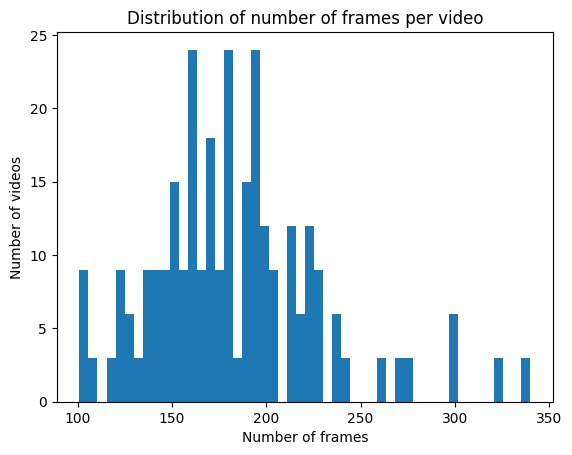

In [3]:
# plot the distribution of number of frames per video
video_lengths = [len(frames) for frames in data.values()]
print(f'Total number of frames: {sum(video_lengths)}')
plt.hist(video_lengths, bins=50)
plt.xlabel('Number of frames')
plt.ylabel('Number of videos')
plt.title('Distribution of number of frames per video')
plt.show()

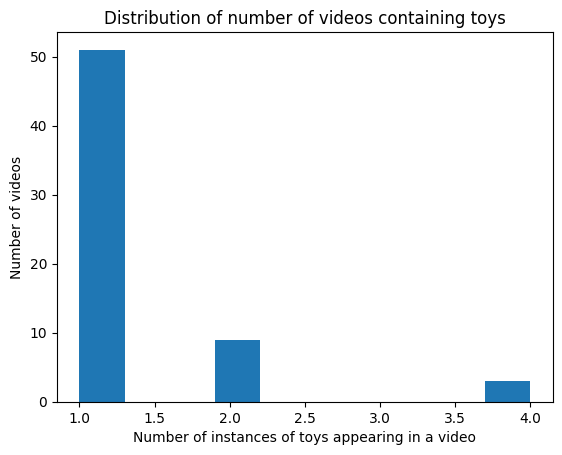

In [4]:
chosen_category = 'toys'
chosen_instances = instances_of_category[chosen_category]

# for each video, count how many different chosen instances show up at all (even if not in every frame)
chosen_counts = defaultdict(int)
for video_id, frames in data.items():
	for chosen_instance in chosen_instances:
		if any(chosen_instance in frames[frame_id] for frame_id in frames):
			chosen_counts[video_id] += 1

plt.hist(list(chosen_counts.values()), align='mid')
plt.xlabel(f'Number of instances of {chosen_category} appearing in a video')
plt.ylabel('Number of videos')
plt.title(f'Distribution of number of videos containing {chosen_category}')
plt.show()

Found instance ID: 517 in video ID: 255
Found instance ID: 517 in video ID: 256
Found instance ID: 517 in video ID: 257
Found instance ID: 517 in video ID: 286
Found instance ID: 517 in video ID: 287
Found instance ID: 517 in video ID: 285
Found instance ID: 519 in video ID: 254
Found instance ID: 519 in video ID: 252
Found instance ID: 519 in video ID: 253
Found instance ID: 519 in video ID: 284
Found instance ID: 519 in video ID: 282
Found instance ID: 519 in video ID: 283
Found instance ID: 523 in video ID: 260
Found instance ID: 523 in video ID: 259
Found instance ID: 523 in video ID: 258
Found instance ID: 523 in video ID: 293
Found instance ID: 523 in video ID: 291
Found instance ID: 523 in video ID: 292
Found instance ID: 472 in video ID: 65
Found instance ID: 472 in video ID: 63
Found instance ID: 472 in video ID: 64
Found instance ID: 472 in video ID: 105
Found instance ID: 472 in video ID: 107
Found instance ID: 472 in video ID: 106
Found instance ID: 474 in video ID: 86
Foun

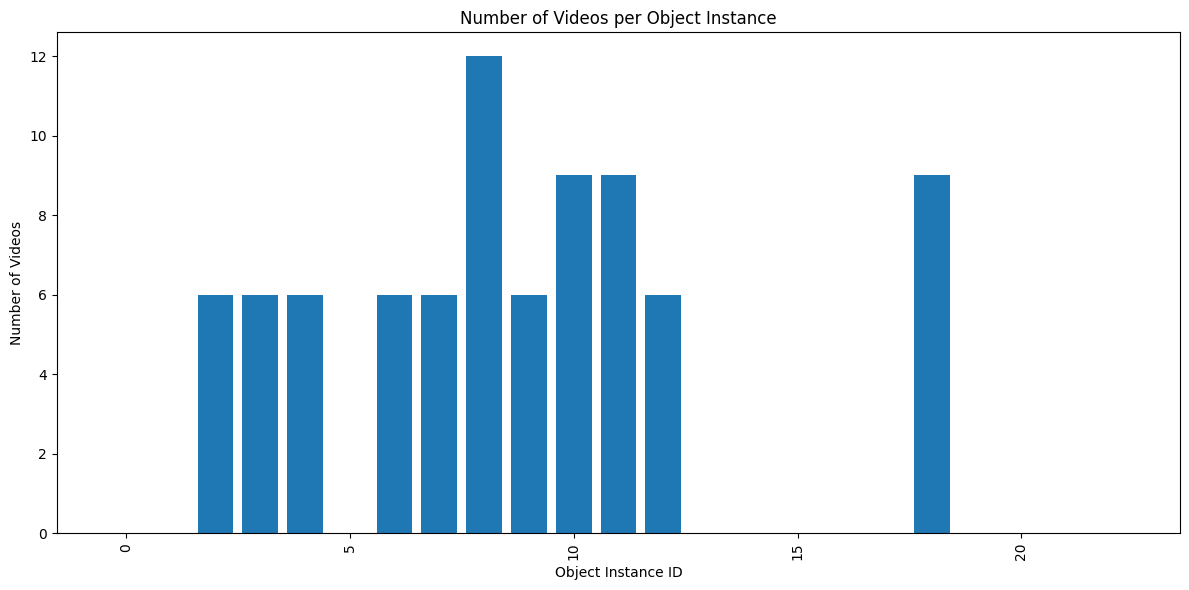

In [5]:
# for each object instance, plot how many videos it appears in (even if it appears in only one frame)
# plot object instance ID on the x axis, and number of videos it appears in on the y axis
# sort from most to least number of videos
instance_video_count = {instance_id: 0 for instance_id in instances_of_category[chosen_category]}
for instance_id in instance_video_count:
	for video_id, frames in data.items():
		if any(instance_id in frames[frame_id] for frame_id in frames):
			print(f"Found instance ID: {instance_id} in video ID: {video_id}")
			instance_video_count[instance_id] += 1

# sort the bars by number of videos
# instance_video_count = dict(sorted(instance_video_count.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(instance_video_count.keys())), instance_video_count.values())
plt.xlabel('Object Instance ID')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Object Instance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
coco_overlap_categories = {'bowl', 'bottle', 'clock', 'handbag', 'remote', 'scissor-link1', 'scissor-link2', 'toothbrush',
                           'brush', 'mug', 'notebook', 'sausage', 'tennis_ball', 'thermos'}

# for i in all_categories: print(i)
eligible_categories = set(all_categories).difference(coco_overlap_categories)

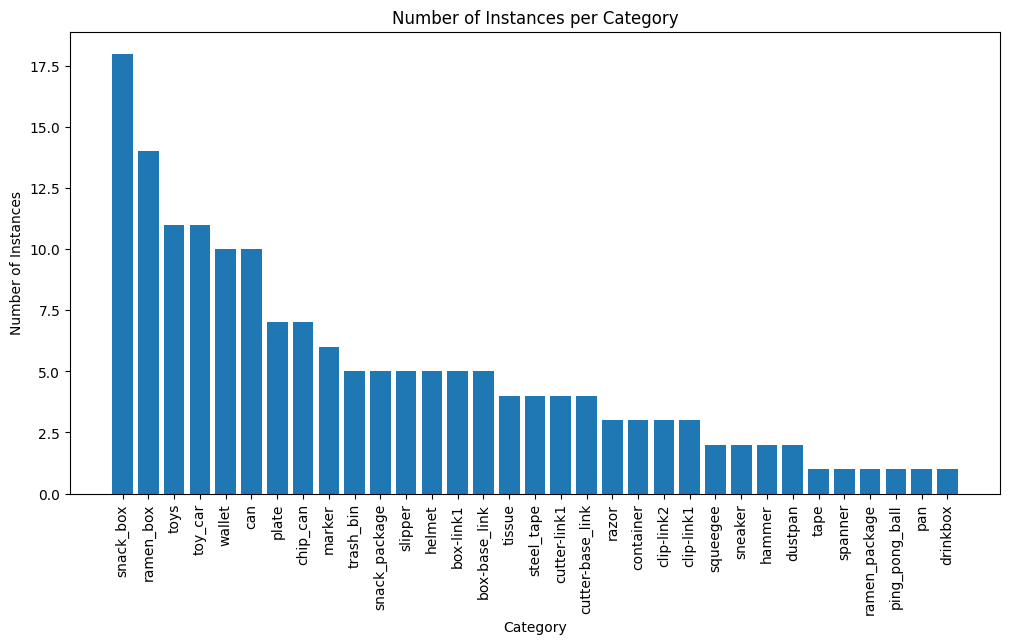

In [31]:
## make histogram of instaces per category
def countVisibleInstances(category):
	count = 0
	for instance in instances_of_category[category]:
		if any(isInstanceInVideo(instance, videoID) for videoID in data.keys()):
			count += 1
	return count

instances_counts = [countVisibleInstances(category) for category in eligible_categories]

# sort categories by number of instances
sorted_categories = [x for _, x in sorted(zip(instances_counts, eligible_categories), reverse=True)]
sorted_counts = sorted(instances_counts, reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(sorted_categories, sorted_counts)
plt.xlabel('Category')
plt.ylabel('Number of Instances')
plt.title(f'Number of Instances per Category')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()

In [ ]:
# plot number of videos that each category occurs in
category_video_counts = defaultdict(int)
for category in all_categories:
	for video_id, frames in data.items():
		foundCategoryInVideo = False
		for frame_id, object_instances in frames.items():
			for instance_id in object_instances:
				if instance_id in instances_of_category[category]:
					category_video_counts[category] += 1
					foundCategoryInVideo = True
					break
			if foundCategoryInVideo:
				break

# plot number of videos that each category occurs in
sorted_categories = [x for _, x in sorted(zip(category_video_counts.values(), category_video_counts.keys()), reverse=True)]
sorted_counts = sorted(category_video_counts.values(), reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(sorted_categories, sorted_counts)
plt.xlabel('Category')
plt.ylabel('Number of Videos')
plt.title(f'Number of Videos per Category')
plt.xticks(rotation=90)
# plt.tight_layout()
plt.show()